In [306]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from uncertainties import *
from scipy.stats import chi2
from matplotlib import gridspec
import pandas
import sys
import statsmodels.api as sm
import warnings ## statsmodels.api is too old ... -_-#
# from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.family"] = "serif" 
plt.rcParams["mathtext.fontset"] = "dejavuserif" 
plt.close("all") # close all existing matplotlib plots
# plt.ion()        # interact with plots without pausing program


In [7]:
!python -V

Python 3.11.0


In [8]:
from joblib import Parallel, delayed

In [9]:
from tqdm.notebook import tqdm

In [331]:
from numba import njit, prange

ModuleNotFoundError: No module named 'numba'

In [10]:
np.finfo(float).eps

2.220446049250313e-16

In [290]:
nx = 1500+1
nz = 1000 +1
xmax = 500 #Micrometers
zmax = (nz/nx)*xmax
dt = 1e-4 # Milliseconds
dx = 2*xmax/(nx-1)
dz = 2*xmax/(nz-1)
hb = 63.5078 #("AtomicMassUnit" ("Micrometers")^2)/("Milliseconds")
m3 = 3   # AtomicMassUnit
m4 = 4 

print(dx, dz, zmax)
print(1j*hb*dt/(2*m4*dx*dz)) #want this to be small

pxmax= (nx+1)/2 * 2*pi/(2*xmax)*hb # want this to be greater than p
pzmax= (nz+1)/2 * 2*pi/(2*zmax)*hb
print(pxmax,pzmax)

0.6666666666666666 1.0 333.4443704197202
0.00119077125j
299.67248816432607 299.7721463251281


In [291]:
wavelength = 1.083 #Micrometers
k = (1/sqrt(2)) * 2*pi / wavelength
p = hb*k
print("k =",k,"1/µm")
print("p =",p, "u*µm/ms")
print("v =",hb*k/m4, "µm/ms")

k = 4.102384984449092 1/µm
p = 260.53344511539603 u*µm/ms
v = 65.13336127884901 µm/ms


In [292]:
a4 = 0.007512
omega = 10 # I don't know, the nature paper used 50 for Rb
V0 = 2*hb*omega
tBraggCenter = 1
tBraggPi = np.sqrt(2*pi*hb)/V0
print(tBraggPi*1000,"µs")

def V(t):
    return V0 * (2*pi)**-0.5 * tBraggPi**-1 * np.exp(-0.5*(t-tBraggCenter)**2 * tBraggPi**-2)


15.727018740679478 µs


In [293]:
print(1j*(dt/hb), "term infront of Bragg potential")
print(1j*(dt/hb)*V(tBraggCenter), "max size of this thing")

1.5746097329776815e-06j term infront of Bragg potential
0.050733363643743784j max size of this thing


In [294]:
# sanity check
assert (pxmax > p or pzmax > p), "momentum resolution too small"

##### Checking parameters reasonable

In [295]:
V0

1270.156

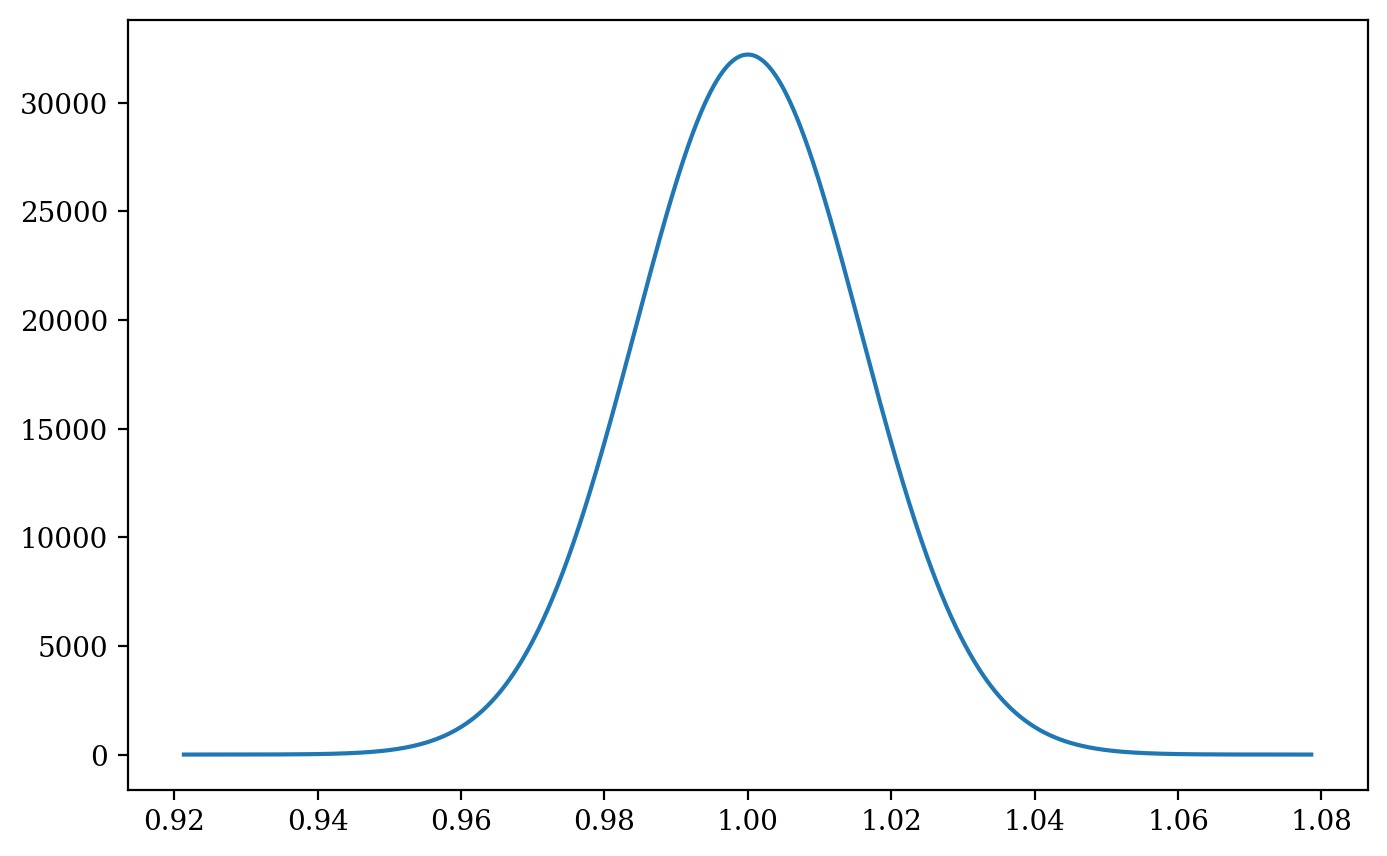

In [296]:
tbtest = np.arange(tBraggCenter-5*tBraggPi,tBraggCenter+5*tBraggPi,dt)
plt.plot(tbtest, V(tbtest))

In [297]:
np.trapz(V(tbtest),tbtest)

1270.1552632290575

#### Initial State

In [298]:
def plot_psi():
    plt.figure(figsize=(12,6))
    extent = np.array([-xmax,+xmax,-zmax,+zmax])*0.001
    plt.subplot(1,3,1)
    plt.imshow(np.abs(psi.T)**2,extent=extent)
    plt.ylabel("$z$ (mm)")
    plt.subplot(1,3,2)
    plt.imshow(np.real(psi.T),extent=extent)
    plt.subplot(1,3,3)
    plt.imshow(np.imag(psi.T),extent=extent)
    plt.show()

In [299]:
def plot_mom():
    plt.figure(figsize=(3,3))
    pspace = np.fft.fftfreq(nx)
    extent = np.array([-pxmax,+pxmax,-pzmax,+pzmax])
    psifft = np.fft.fftshift(np.fft.fft2(psi))
#     plotdata = ((np.abs(psifft)**2).T)[:,::-1] # weird flipping????
#     plotdata = ((np.abs(psifft)**2).T) # weird flipping????
    plotdata = np.flipud((np.abs(psifft)**2).T)
    plt.imshow(plotdata,extent=extent)
    plt.show()

In [300]:
xlin = np.linspace(-xmax,+xmax, nx)
zlin = np.linspace(-zmax,+zmax, nz)
psi=np.zeros((nx,nz),dtype=complex)

zones = np.ones(nz)
xgrid = np.tensordot(xlin,zones,axes=0)

print(nx**2/1000/1000,"million grid points")
print((nx**2)*0.001/60/60,"hours (for 1ms per operation)")
print(psi.nbytes/1000/1000, "MB of data used")

2.2530010000000003 million grid points
0.6258336111111112 hours (for 1ms per operation)
24.040016 MB of data used


In [301]:
np.arange(10)[::-1]

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

In [302]:
sg=0.2

def psi0(x,z,sx=sg,sz=sg,px=0,pz=0):
    return (1/np.sqrt(pi*sx*sz)) \
            * np.exp(-0.5*x**2/sx**2) \
            * np.exp(-0.5*z**2/sz**2) \
            * np.exp(+(1j/hb)*(px*x + pz*z))

0.9999999999999994 normalisation check


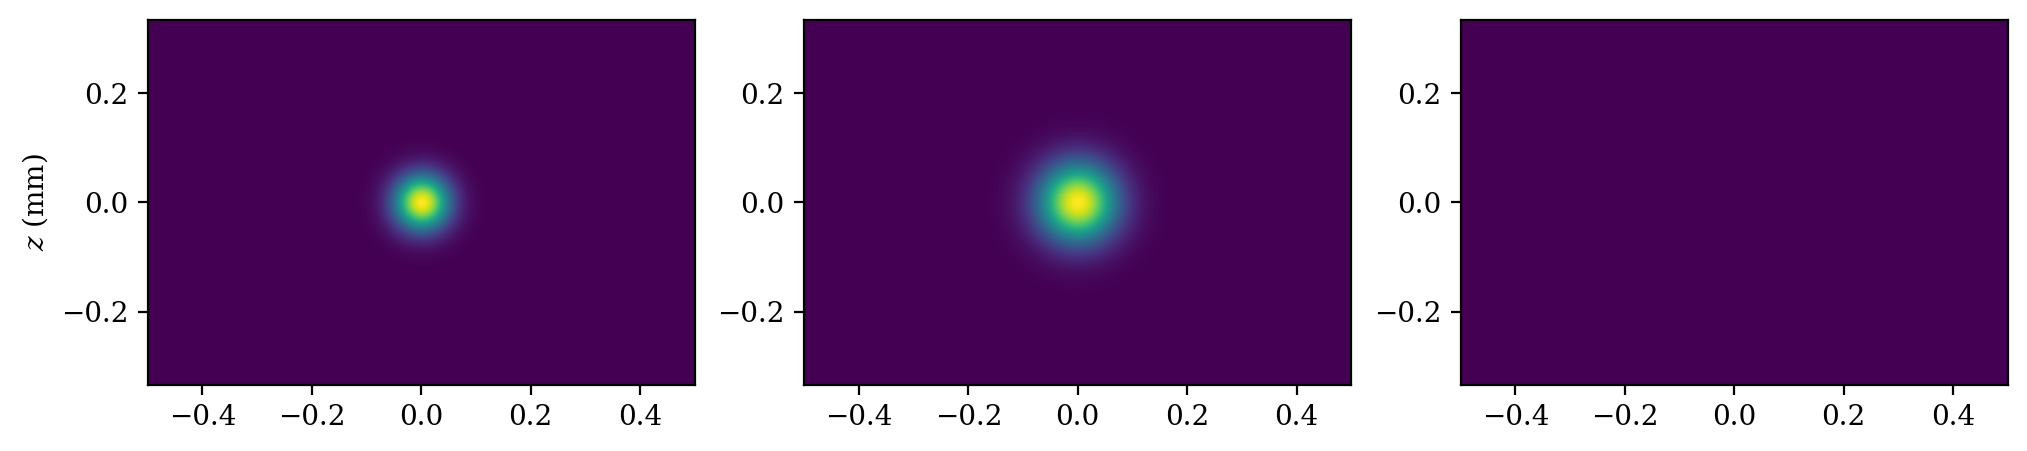

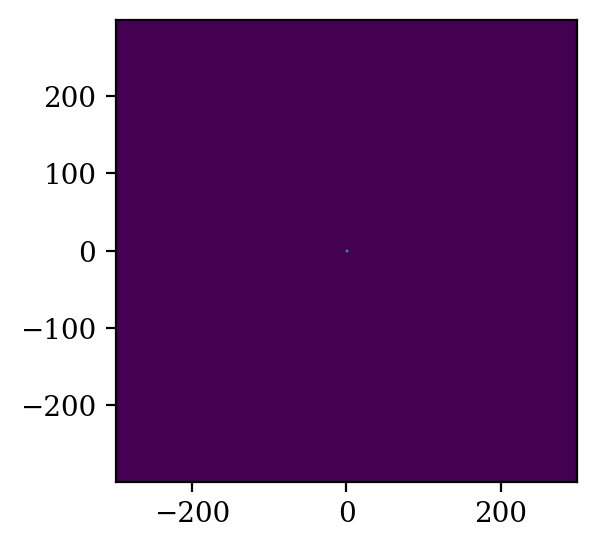

In [326]:
for ix in range(1,nx-1):
    x = xlin[ix]
    psi[ix][1:-1] = psi0(x,zlin[1:-1],50,50,0,0)
t = 0
print(np.trapz(np.trapz(np.abs(psi)**2,xlin,axis=0),zlin), "normalisation check")

plot_psi()
plot_mom()

In [329]:
def run(): # basically so that i can run this in a different cell and keep its output
    global t
    step = 0
    def generator():
      while True:
        yield

    # while True:
    for _ in tqdm(generator()):
        psi[1:-1,1:-1] += 1j*hb*dt/(2*m4*dx**2)*(\
                psi[2:,1:-1] + psi[:-2,1:-1] + psi[1:-1,2:] + psi[1:-1,:-2] - 4*psi[1:-1,1:-1] )\
              - 1j*(dt/hb)*np.multiply( V(t)*np.cos(2*k*xgrid[1:-1,1:-1]), psi[1:-1,1:-1] )

        t += dt 
        step += 1 
        if (step*dt*1000*1000) % (100*1000) == 0:
            print(int(t*1000),"µs, step =", step) 
            argmax = np.argmax(psi)
            print(argmax//nx, argmax%nx)
            print(np.sum(np.abs(psi)**2)*dx**2,"|psi|^2")
            plot_psi()
        if (step*dt*1000*1000) % (500*1000) == 0:
            plot_mom()

0it [00:00, ?it/s]

100 µs, step = 1000
500 750
0.9996669998687154 |psi|^2


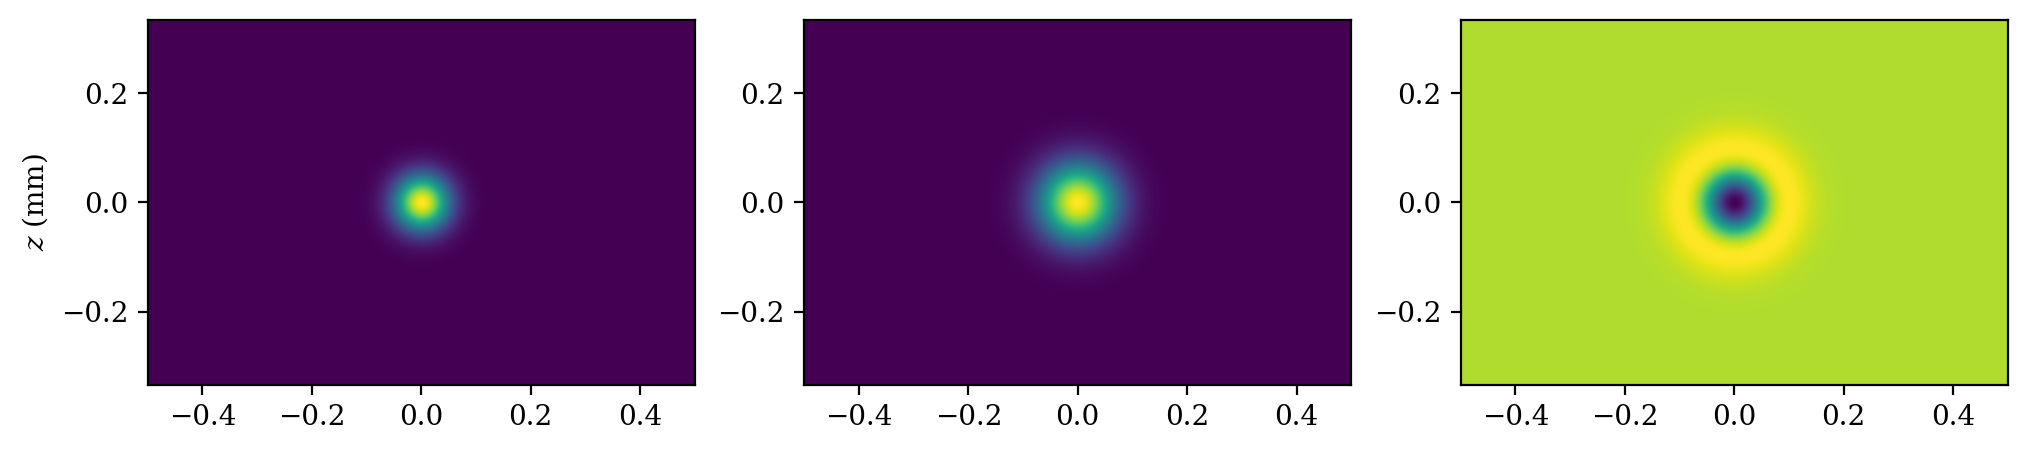

199 µs, step = 2000
500 750
0.9996670000704322 |psi|^2


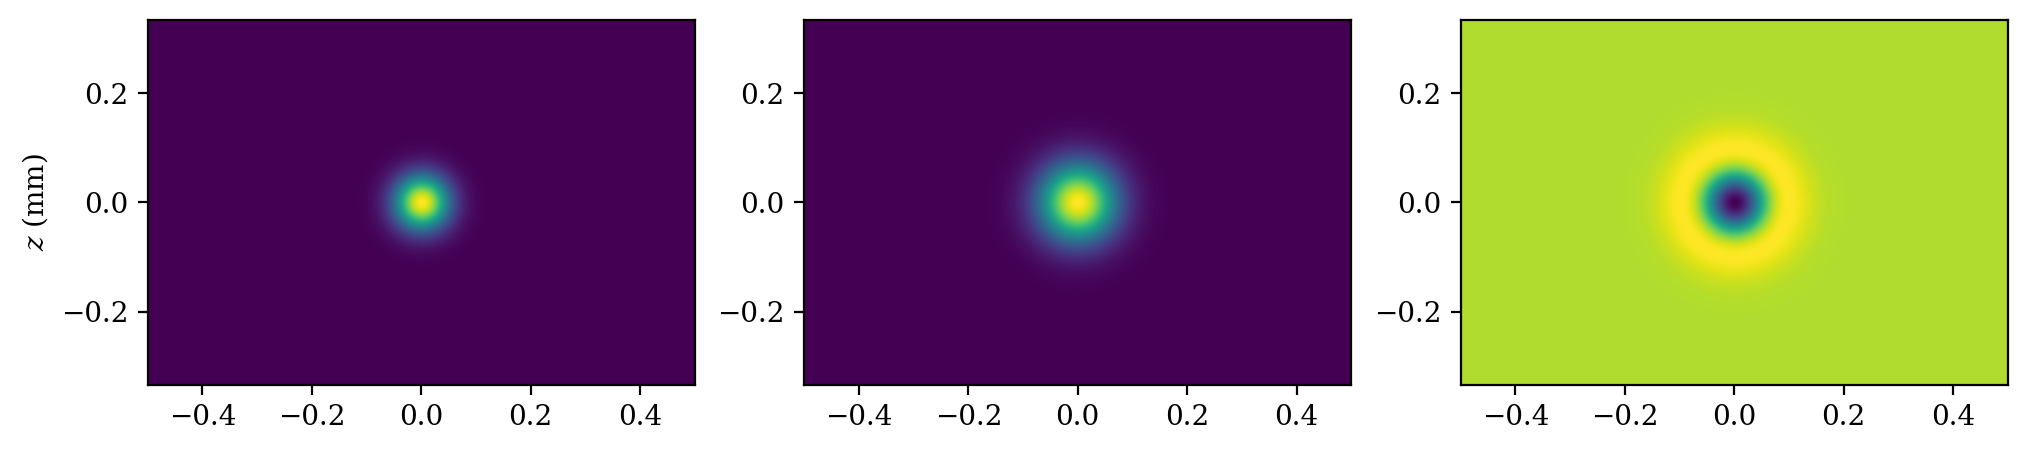

299 µs, step = 3000
500 750
0.9996670002721476 |psi|^2


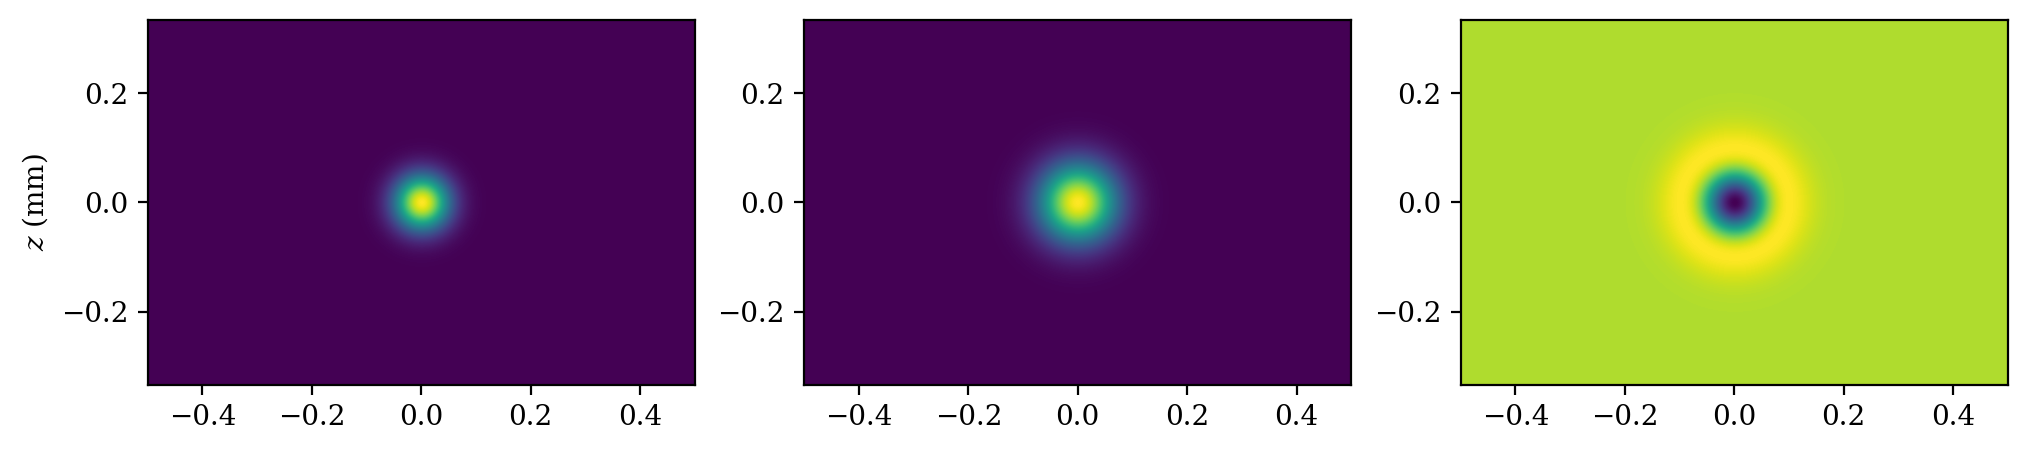

399 µs, step = 4000
500 750
0.9996670004738628 |psi|^2


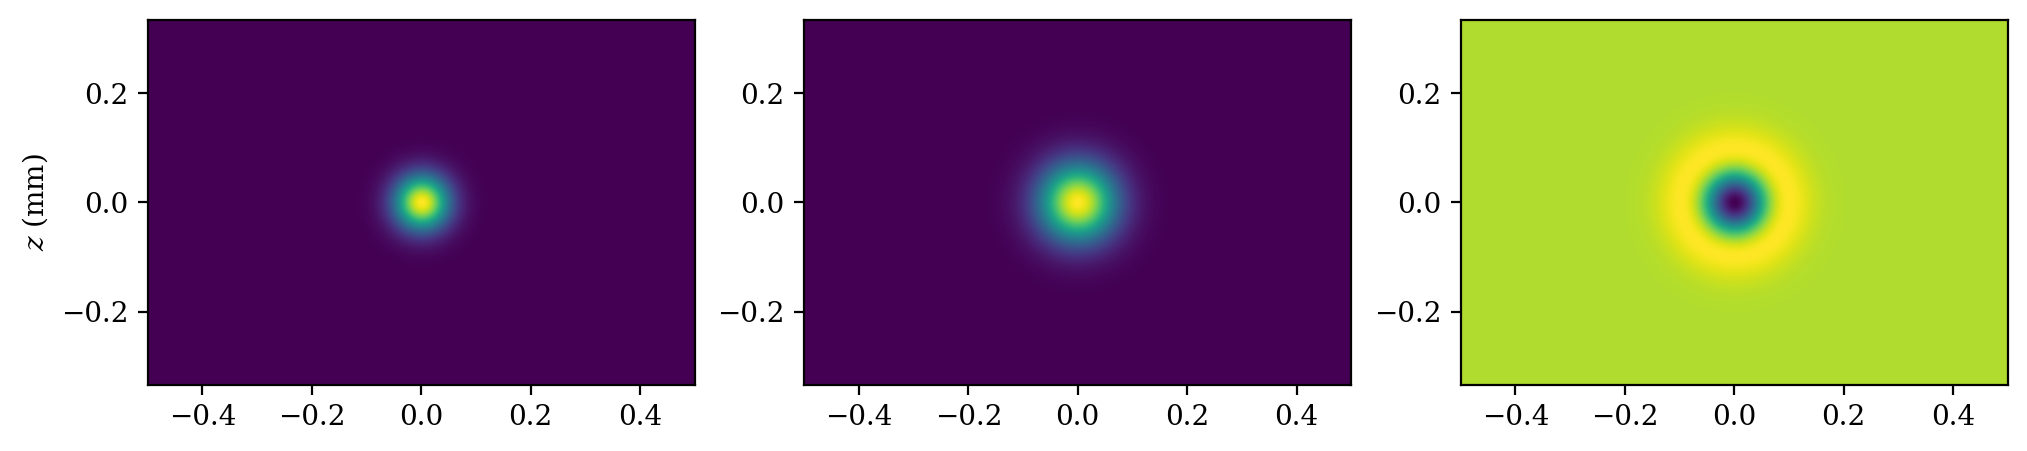

499 µs, step = 5000
500 750
0.999667000675579 |psi|^2


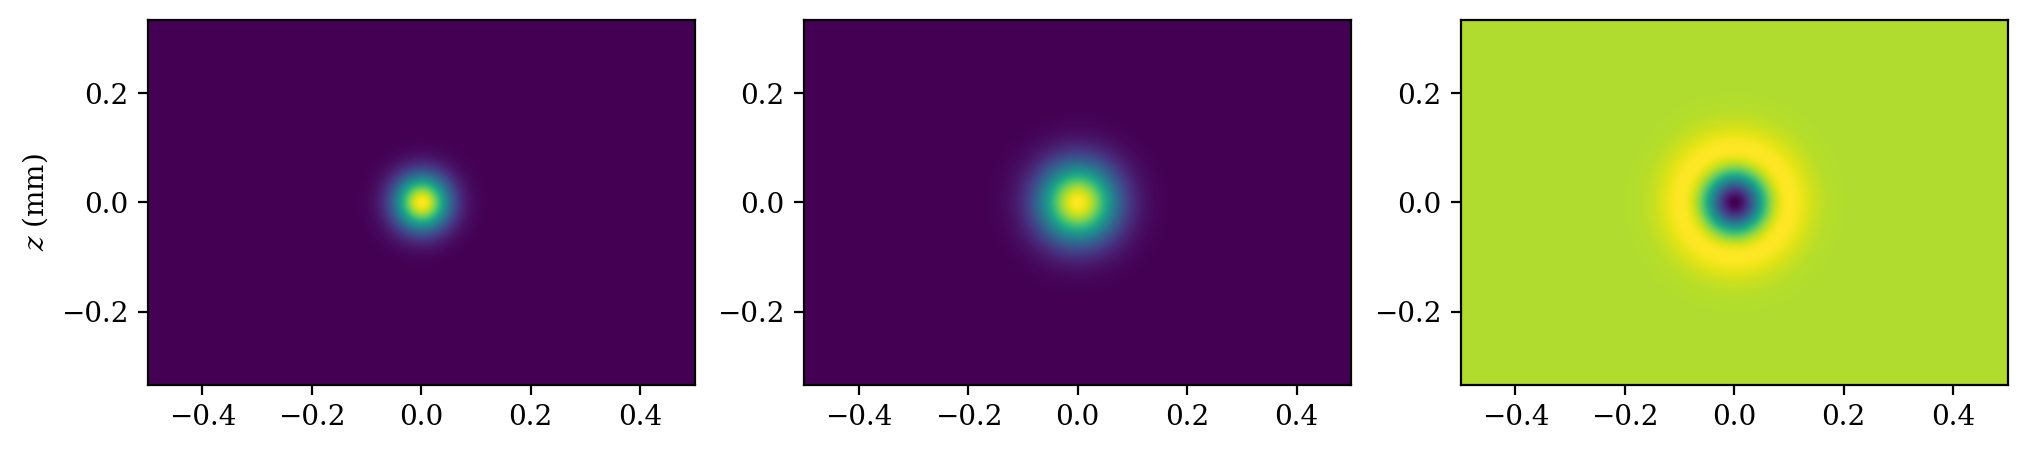

599 µs, step = 6000
500 750
0.9996670008772945 |psi|^2


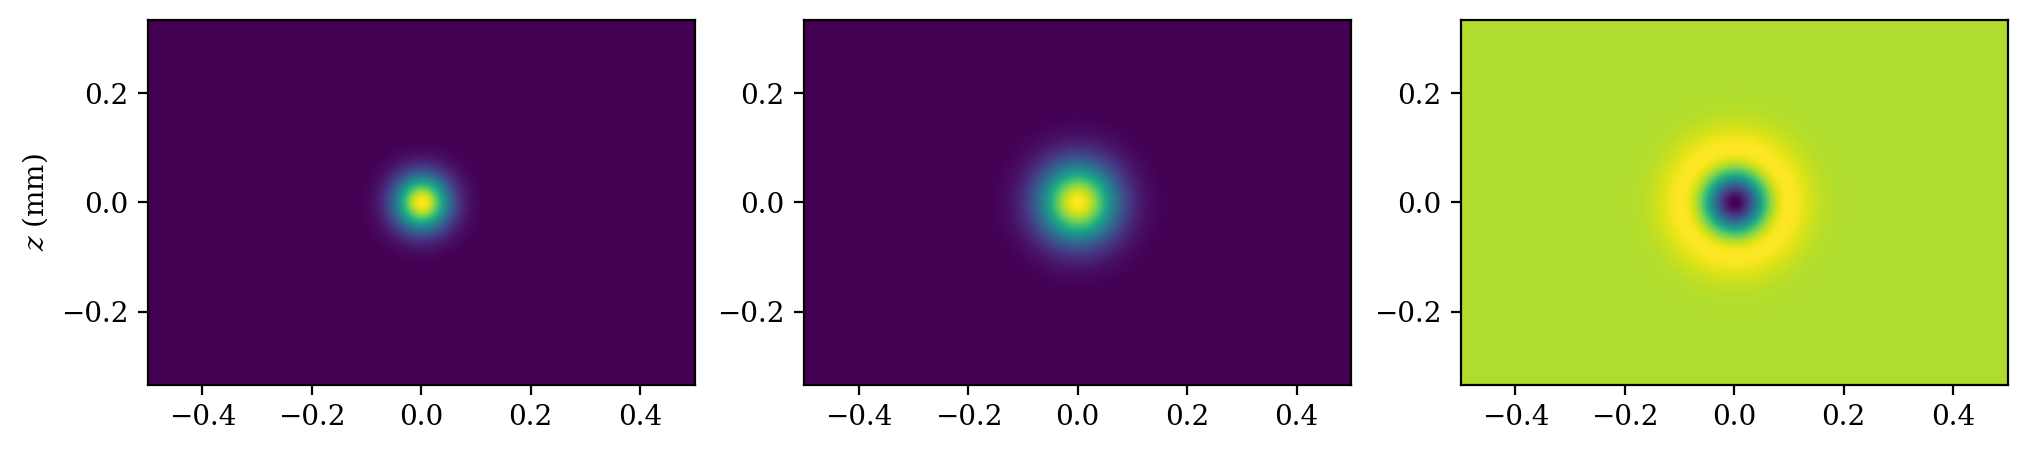

799 µs, step = 8000
500 750
0.9996670012807263 |psi|^2


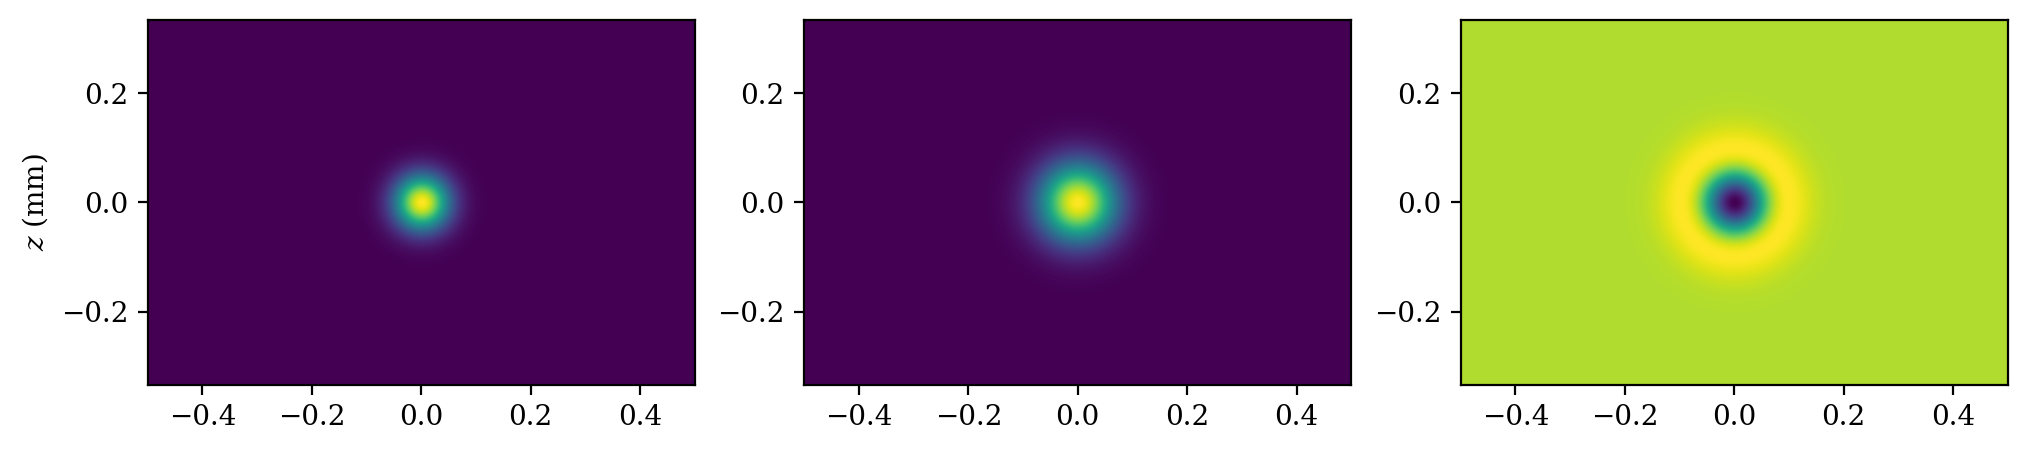

899 µs, step = 9000
500 750
0.9996670014824419 |psi|^2


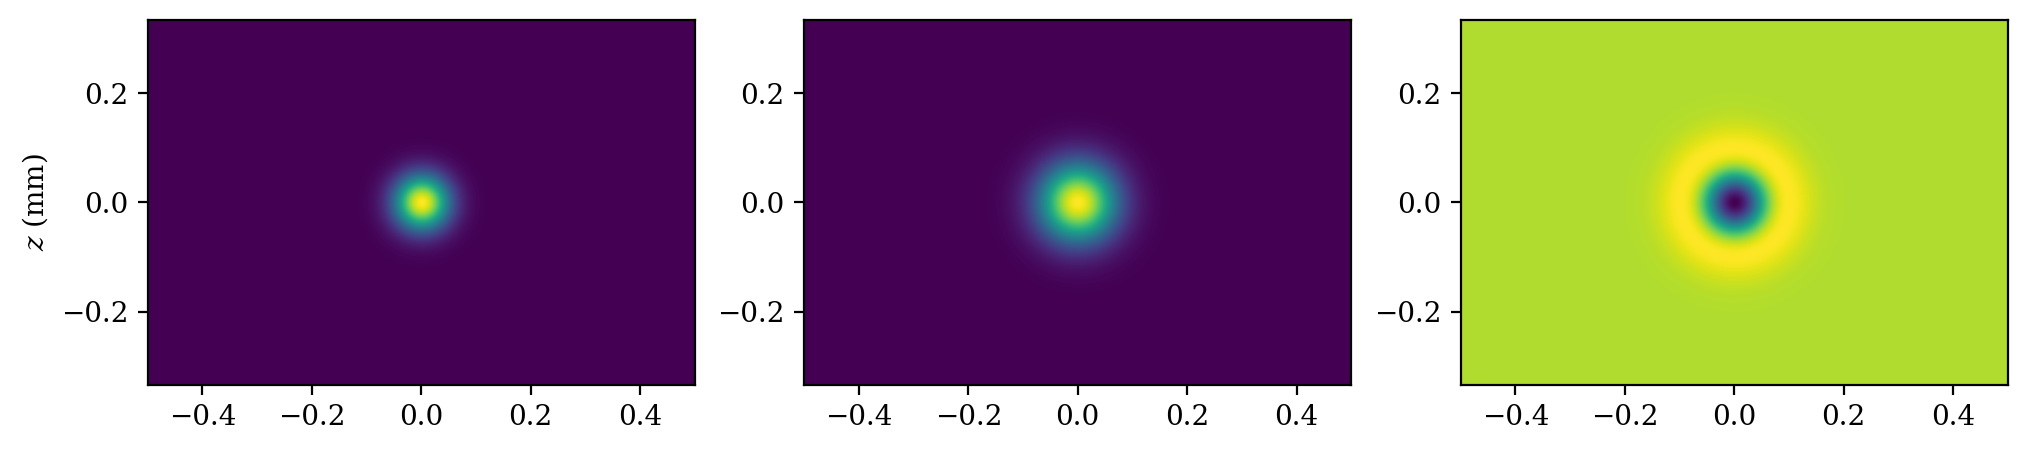

KeyboardInterrupt: 

In [328]:
run()

0it [00:00, ?it/s]

1008 µs, step = 1000
503 251
1.341249577767979 |psi|^2


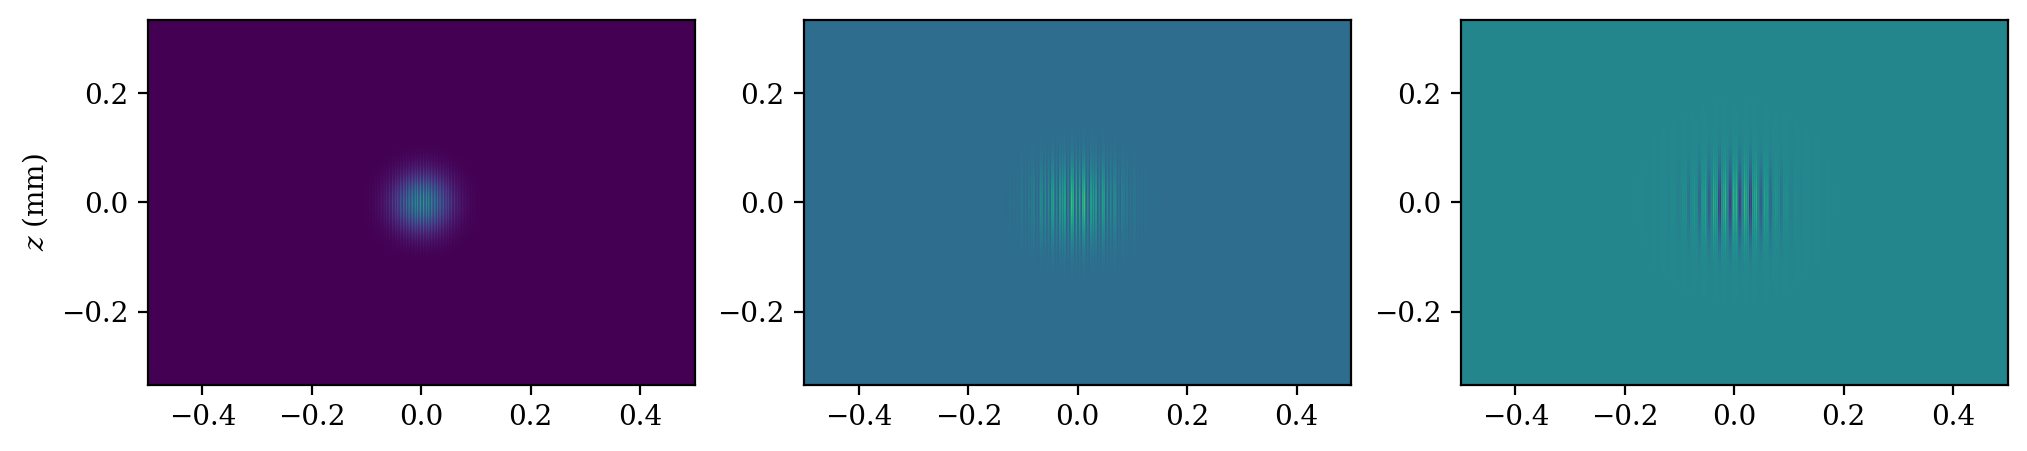

1108 µs, step = 2000
477 238
1.4972618967853892 |psi|^2


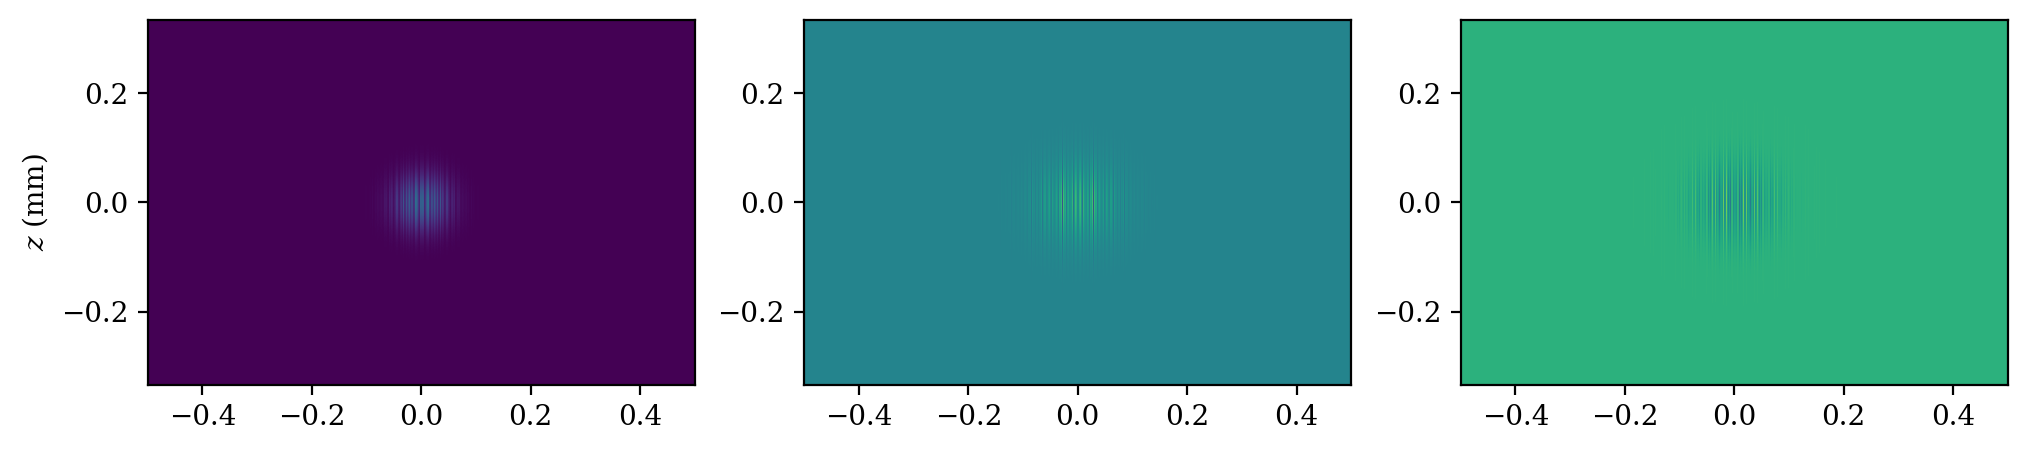

1208 µs, step = 3000
484 742
1.524223589793324 |psi|^2


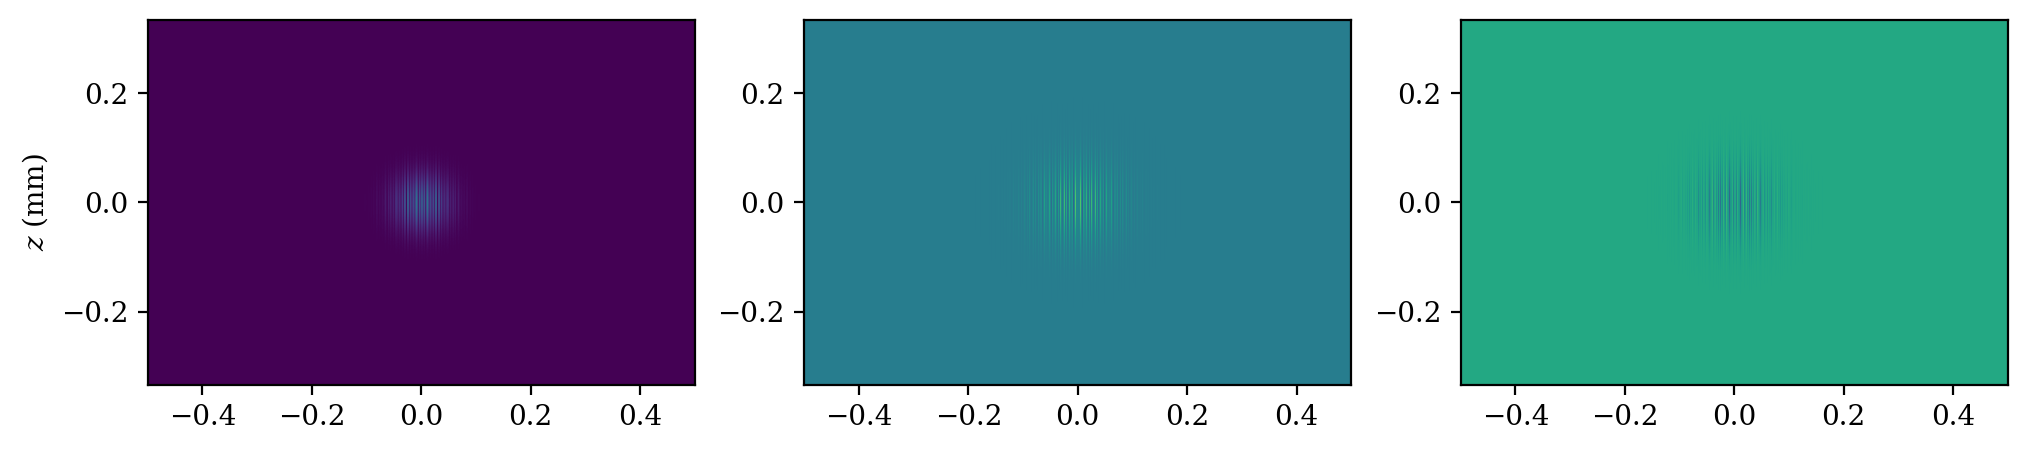

1308 µs, step = 4000
494 747
1.5521331394055002 |psi|^2


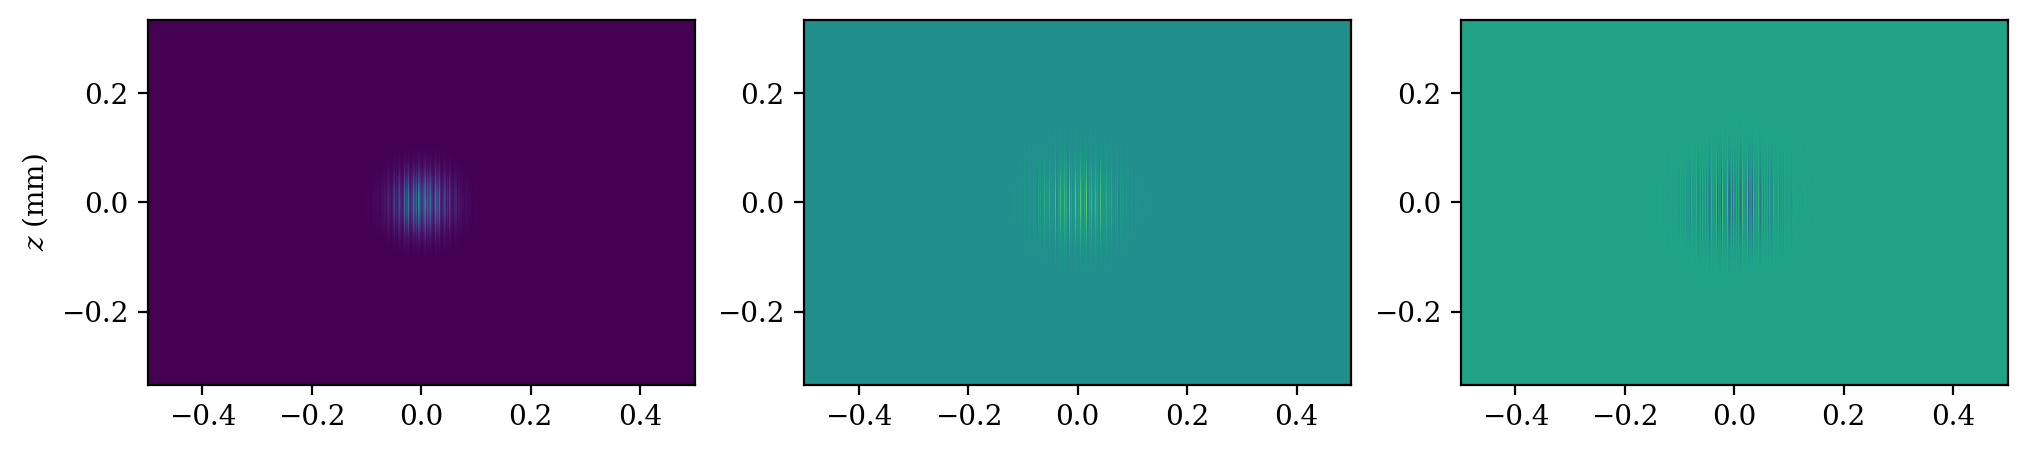

1408 µs, step = 5000
506 753
1.581029146756928 |psi|^2


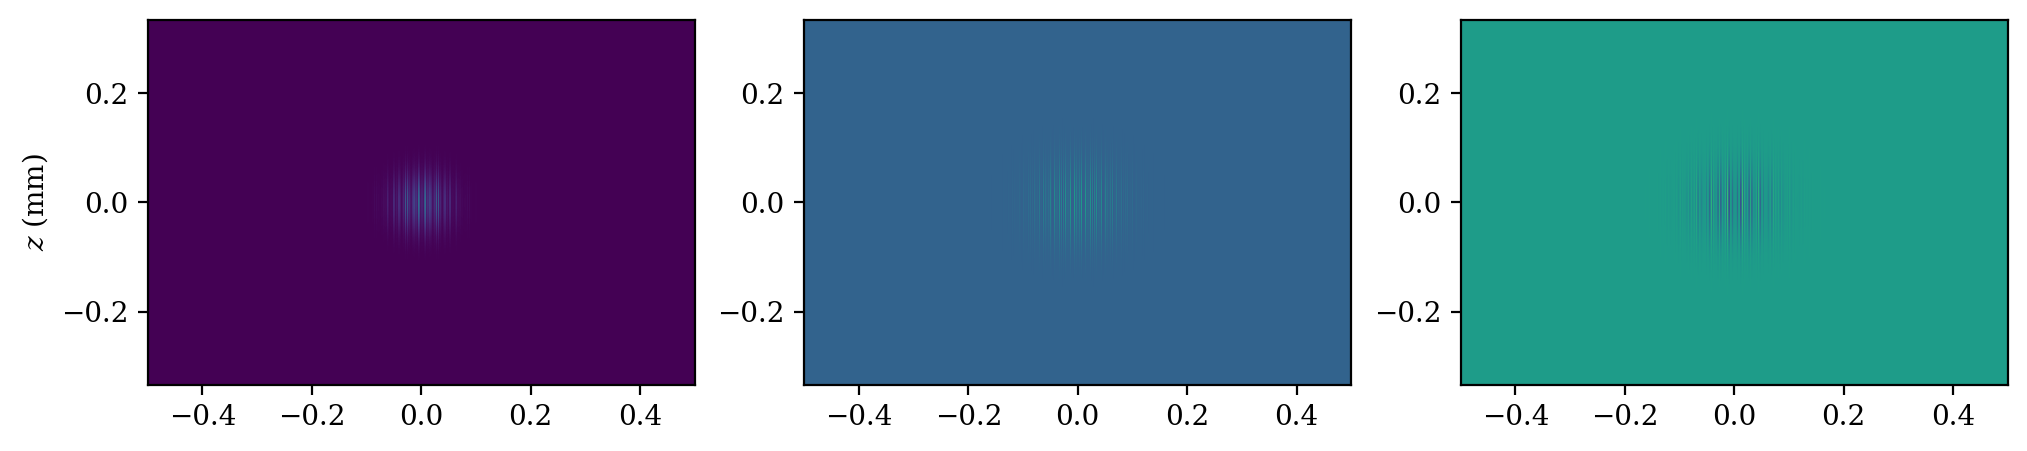

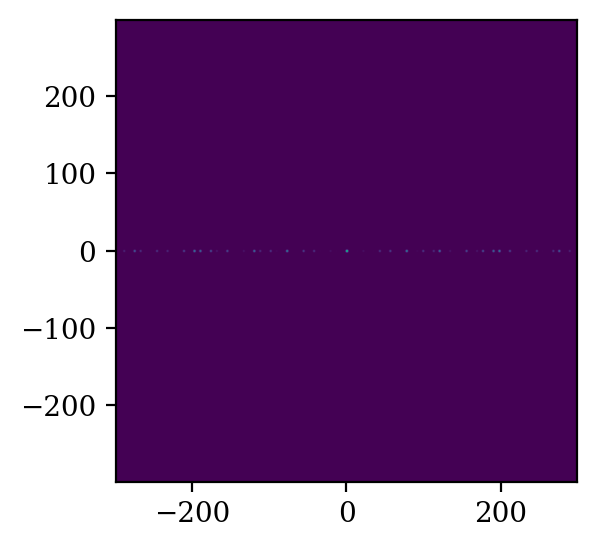

KeyboardInterrupt: 

In [330]:
run()